# 05 - Final Model Comparison & Evaluation

## Section E: Evaluation, Robustness & Scalability

This notebook provides comprehensive evaluation including:
- Performance metrics comparison across data scales
- Robustness analysis (noise sensitivity)
- Scalability analysis (throughput, memory)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from config import PROCESSED_DATA_DIR, RESULTS_DIR, RANDOM_STATE
from src.evaluation import (
    compute_metrics, evaluate_at_scales, evaluate_robustness_noise,
    plot_roc_curves, plot_precision_recall_curves,
    generate_evaluation_report
)
from src.visualization import plot_scale_performance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print('Imports successful!')

Imports successful!


In [2]:
# Load models
try:
    rf_model = joblib.load(RESULTS_DIR / 'randomforest_model.joblib')
    xgb_model = joblib.load(RESULTS_DIR / 'xgboost_model.joblib')
    print('Models loaded successfully!')
except:
    print('Models not found. Run notebook 03 first.')
    raise

Models loaded successfully!


In [3]:
# Load and prepare data
df = pd.read_csv(PROCESSED_DATA_DIR / 'loan_data_processed.csv')

X = df.drop(columns=['default', 'loan_status'], errors='ignore')
y = df['default']

# Encode categorical
cat_cols = X.select_dtypes(include=['object', 'string']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'Test set size: {len(X_test):,}')

Test set size: 261,278


## Metric Selection Justification

For **loan default prediction**, we prioritize:

1. **ROC-AUC**: Overall discriminative ability across all thresholds
2. **Recall (Sensitivity)**: Critical to identify actual defaults (minimize FN)
3. **Precision-Recall AUC**: Better metric for imbalanced datasets
4. **F1-Score**: Harmonic mean balancing precision and recall

**Why not just Accuracy?** With 80% non-defaults, a naive classifier achieves 80% accuracy by predicting all non-defaults. This is useless for risk management.

In [4]:
print('='*60)
print('COMPREHENSIVE MODEL EVALUATION')
print('='*60)

models = {'RandomForest': rf_model, 'XGBoost': xgb_model}

for name, model in models.items():
    print(f'\n--- {name} ---')
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = compute_metrics(y_test, y_pred, y_proba)
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f'{metric}: {value:.4f}')

COMPREHENSIVE MODEL EVALUATION

--- RandomForest ---
accuracy: 0.7991
precision: 0.0000
recall: 0.0000
f1: 0.0000
specificity: 1.0000
roc_auc: 0.5282
pr_auc: 0.2115

--- XGBoost ---
accuracy: 0.7964
precision: 0.3960
recall: 0.0254
f1: 0.0478
specificity: 0.9902
roc_auc: 0.6243
pr_auc: 0.2919


## Scalability Analysis

In [5]:
print('\n' + '='*60)
print('SCALABILITY ANALYSIS')
print('='*60)

scales = [0.1, 0.25, 0.5, 0.75, 1.0]

for name, model in models.items():
    print(f'\n--- {name} ---')
    scale_results = evaluate_at_scales(model, X_test, y_test, scales=scales)
    print(scale_results[['scale', 'n_samples', 'roc_auc', 'throughput']].to_string(index=False))


SCALABILITY ANALYSIS

--- RandomForest ---
 scale  n_samples  roc_auc   throughput
  0.10      26127 0.525901 1.009698e+06
  0.25      65319 0.529234 1.522576e+06
  0.50     130639 0.526761 1.615117e+06
  0.75     195958 0.527502 1.868579e+06
  1.00     261278 0.528201 1.654685e+06

--- XGBoost ---
 scale  n_samples  roc_auc   throughput
  0.10      26127 0.623584 4.282320e+06
  0.25      65319 0.624756 4.490906e+06
  0.50     130639 0.623021 5.372326e+06
  0.75     195958 0.623296 5.602183e+06
  1.00     261278 0.624285 4.748466e+06


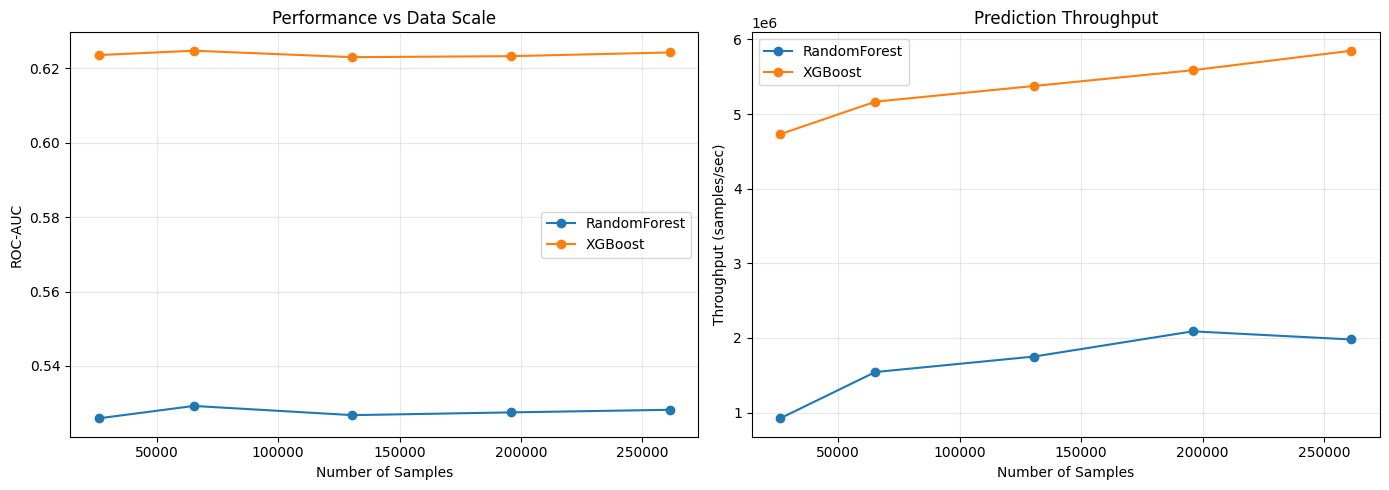

In [6]:
# Visualize scalability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, model in models.items():
    scale_results = evaluate_at_scales(model, X_test, y_test, scales=scales)
    
    axes[0].plot(scale_results['n_samples'], scale_results['roc_auc'], 'o-', label=name)
    axes[1].plot(scale_results['n_samples'], scale_results['throughput'], 'o-', label=name)

axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('Performance vs Data Scale')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Throughput (samples/sec)')
axes[1].set_title('Prediction Throughput')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'scalability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Robustness to Noise

In [7]:
print('\n' + '='*60)
print('ROBUSTNESS TO NOISE')
print('='*60)

noise_levels = [0, 0.05, 0.1, 0.2, 0.3]

for name, model in models.items():
    print(f'\n--- {name} ---')
    noise_results = evaluate_robustness_noise(model, X_test, y_test, noise_levels=noise_levels)
    print(noise_results[['noise_level', 'accuracy', 'f1', 'roc_auc']].to_string(index=False))


ROBUSTNESS TO NOISE

--- RandomForest ---
 noise_level  accuracy  f1  roc_auc
        0.00  0.799103 0.0 0.528201
        0.05  0.799103 0.0 0.527376
        0.10  0.799103 0.0 0.527274
        0.20  0.799103 0.0 0.529585
        0.30  0.799103 0.0 0.527213

--- XGBoost ---
 noise_level  accuracy       f1  roc_auc
        0.00  0.796420 0.047797 0.624285
        0.05  0.796983 0.035809 0.614632
        0.10  0.796615 0.041002 0.613589
        0.20  0.794843 0.049744 0.612448
        0.30  0.792765 0.062894 0.608282


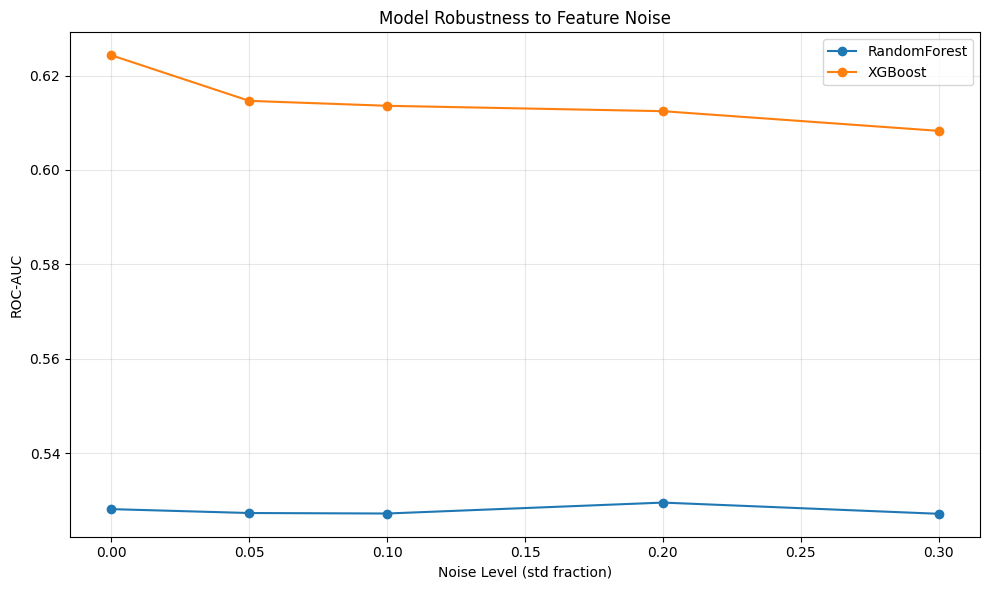

In [8]:
# Visualize robustness
fig, ax = plt.subplots(figsize=(10, 6))

for name, model in models.items():
    noise_results = evaluate_robustness_noise(model, X_test, y_test, noise_levels=noise_levels)
    ax.plot(noise_results['noise_level'], noise_results['roc_auc'], 'o-', label=name)

ax.set_xlabel('Noise Level (std fraction)')
ax.set_ylabel('ROC-AUC')
ax.set_title('Model Robustness to Feature Noise')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'robustness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Generalization Limitations

### Identified Limitations:

1. **Temporal drift**: Model trained on historical data may not generalize to future economic conditions
2. **Geographic bias**: Lending Club data is US-centric; may not apply to other markets
3. **Feature availability**: Some features may not be available in real-time scoring
4. **Selection bias**: Only approved loans are in the dataset (rejected applications excluded)

In [9]:
# Final summary
print('\n' + '='*60)
print('EVALUATION SUMMARY')
print('='*60)

summary = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, y_pred, y_proba)
    
    summary.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1'],
        'ROC-AUC': metrics['roc_auc'],
        'PR-AUC': metrics.get('pr_auc', 0)
    })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

summary_df.to_csv(RESULTS_DIR / 'final_evaluation.csv', index=False)
print('\nResults saved!')


EVALUATION SUMMARY
       Model  Accuracy  Precision   Recall       F1  ROC-AUC   PR-AUC
RandomForest  0.799103   0.000000 0.000000 0.000000 0.528201 0.211486
     XGBoost  0.796420   0.396025 0.025433 0.047797 0.624285 0.291859

Results saved!
